In [1]:
import pandas as pd
main = pd.read_csv("sales_train")
test = pd.read_csv("sales_test")
shops = pd.read_csv('shops')
items = pd.read_csv('items')
cats = pd.read_csv('item_categories')

In [2]:
main.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
#NULL DATA CHECK
#Check for missing values
main.isnull().sum()
#No columns contain null values

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [5]:
#DATA LEAK
#We check if all shop_id in test is found in train
test['shop_id'].unique().any() not in main['shop_id'].unique().tolist()

False

In [6]:
#DATA LEAK
#We check if all item_id in test is found in train
test['item_id'].unique().any() not in main['item_id'].unique().tolist()

False

In [7]:
#DATA LEAK
#We use only data that contains item_id & shop_id in test
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
leak_train = main[main['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
leak_train = leak_train[leak_train['item_id'].isin(test_item_ids)]

print('Data set size before leaking:', main.shape[0])
print('Data set size after leaking:', leak_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


In [8]:
#THIS IS WHERE WE REMOVE OUTLIERS
#REFER TO EDA SECTION FOR CHOICE OF THRESHOLDS
leak_train = leak_train[leak_train['item_price']<100000]
leak_train = leak_train[leak_train['item_cnt_day']<1001]

In [9]:
leak_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,1224438.0,19.354711,9.110718,0.0,12.0,21.0,27.0,33.0
shop_id,1224438.0,32.151183,16.465621,2.0,19.0,31.0,46.0,59.0
item_id,1224438.0,9614.864386,6299.872707,30.0,4181.0,7856.0,15229.0,22167.0
item_price,1224438.0,1030.666832,1827.384271,0.5,299.0,549.0,1199.0,59200.0
item_cnt_day,1224438.0,1.319464,2.671780,-16.0,1.0,1.0,1.0,1000.0


In [10]:
#DATA PRE-PROCESSING
#Let's check first part of shop_name
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [11]:
#DATA PRE-PROCESSING
#First part of shop_name is city name, except for 'Интернет-магазин'
#However, some city names are not properly-written. Let's fix them before label-encoding city names
from sklearn.preprocessing import LabelEncoder
shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
#If subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [12]:
#DATA PRE-PROCESSING
print('No. of shops is {} & no. of unique items is {}.'.format(test['shop_id'].nunique(),test['item_id'].nunique()))
assert len(test) == test['shop_id'].nunique() * test['item_id'].nunique()
#Interestingly, test set includes item pairs for every shop. However, train set only contains sold or returned items.
#We need to replicate these pairs in the train set as well.

No. of shops is 42 & no. of unique items is 5100.


In [13]:
#DATA PRE-PROCESSING
from itertools import product
import numpy as np
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    leak_train_filtered = leak_train[leak_train['date_block_num'] == i]
    matrix.append(np.array(list(product([i], leak_train_filtered['shop_id'].unique(), leak_train_filtered['item_id'].unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

#leak_train['revenue'] = leak_train['item_price'] *  leak_train['item_cnt_day']

group = leak_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

main_combined = pd.merge(matrix, group, on=cols, how='left')
main_combined['item_cnt_month'] = (main_combined['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))



In [ ]:
main_combined['revenue'] = main_combined['item_price'] *  main_combined['item_cnt_day']

In [14]:
#DATA PRE-PROCESSING
#Note that summing up item_cnt_month will return infinite since it exceeds maximum range
np.sum(main_combined['item_cnt_month'])

inf

In [15]:
#DATA PRE-PROCESSING
#We do the same for test
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

test = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
test.fillna(0, inplace=True)

In [16]:
#MERGE 
main_combined = pd.merge(main_combined, shops, on=['shop_id'], how='left')
main_combined = pd.merge(main_combined, items, on=['item_id'], how='left')
main_combined = pd.merge(main_combined, cats, on=['item_category_id'], how='left')

In [17]:
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,32,0.0,0,40,11,4
1,0,2,33,1.0,0,37,11,1
2,0,2,42,0.0,0,57,13,8
3,0,2,45,0.0,0,57,13,8
4,0,2,51,0.0,0,57,13,8


In [18]:
#DATA PRE-PROCESSING ON MERGED DATA

In [19]:
#DATA PRE-PROCESSING
# Select only useful features.
#train_monthly = leak_train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day','item_category_id']]
# Group by month in this case "date_block_num" and aggregate features.
#train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id', 'item_category_id'], as_index=False)
#train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
#train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_category_id', 'item_cnt', 'mean_item_cnt', 'transactions']
#train_monthly.head()

In [20]:
#DATA PRE-PROCESSING
main_combined['year'] = main_combined['date_block_num'].apply(lambda x:(x//12))
main_combined['month'] = main_combined['date_block_num'].apply(lambda x: (x % 12))
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
main_combined['days'] = main_combined['month'].map(days).astype(np.int8)
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,year,month,days
0,0,2,32,0.0,0,40,11,4,0,0,31
1,0,2,33,1.0,0,37,11,1,0,0,31
2,0,2,42,0.0,0,57,13,8,0,0,31
3,0,2,45,0.0,0,57,13,8,0,0,31
4,0,2,51,0.0,0,57,13,8,0,0,31


In [21]:
#EXPLORATORY DATA ANALYSIS [FOR ORIGINAL DATASET]
#BASIC STATS

In [22]:
#EXPLORATORY DATA ANALYSIS
main = leak_train
main.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,1.224438e+06,1.224438e+06,1.224438e+06,1.224438e+06,1.224438e+06
mean,1.935471e+01,3.215118e+01,9.614864e+03,1.030667e+03,1.319464e+00
std,9.110718e+00,1.646562e+01,6.299873e+03,1.827384e+03,2.671780e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,5.000000e-01,-1.600000e+01
25%,1.200000e+01,1.900000e+01,4.181000e+03,2.990000e+02,1.000000e+00
50%,2.100000e+01,3.100000e+01,7.856000e+03,5.490000e+02,1.000000e+00
75%,2.700000e+01,4.600000e+01,1.522900e+04,1.199000e+03,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,5.920000e+04,1.000000e+03


In [23]:
#EXPLORATORY DATA ANALYSIS
#Features unique values
for col in main.columns:
    print("Number of unique values of {} : {}".format(col, main[col].nunique()))    
#This data is over 34 months
#There are 42 different shops, 12 are redundant
#Many different item_ids, many repetitions
#Many different item_prices. However, unique values is higher than that of item_id. This shows that many items have different prices over time.

Number of unique values of date : 1034
Number of unique values of date_block_num : 34
Number of unique values of shop_id : 42
Number of unique values of item_id : 4716
Number of unique values of item_price : 11940
Number of unique values of item_cnt_day : 161


In [24]:
#EXPLORATORY DATA ANALYSIS
#Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
#shop_ids = train_monthly['shop_id'].unique()
#item_ids = train_monthly['item_id'].unique()
#empty_df = []
#for i in range(34):
#    for shop in shop_ids:
#        for item in item_ids:
#            empty_df.append([i, shop, item])
    
#empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [25]:
#EXPLORATORY DATA ANALYSIS
#Merge the train set with the complete set (missing records will be filled with 0).
#train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
#train_monthly.fillna(0, inplace=True)

In [26]:
#EXPLORATORY DATA ANALYSIS
#SALES/TRANSACTIONS TRENDS

In [27]:
#EXPLORATORY DATA ANALYSIS
#Lets view the trend of item_cnt,mean_item_cnt,transactions over time
#We begin by importing matplotlib
ts = main.groupby('date_block_num')['item_cnt_day'].sum()
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('item_cnt over months')
plt.xlabel('month')
plt.ylabel('item_cnt')
plt.plot(ts)

ts = main.groupby('date_block_num')['item_cnt_day'].mean()
plt.subplot(312)
plt.title('mean_item_cnt over months')
plt.xlabel('month')
plt.ylabel('mean_item_cnt')
plt.plot(ts)
plt.plot()

ts = main.groupby('date_block_num')['date_block_num'].count()
plt.subplot(313)
plt.title('transactions over months')
plt.xlabel('month')
plt.ylabel('transactions')
plt.plot(ts)
plt.plot()

#We observe 2 "spikes" in the data. They seem to be located at end of each year, implying seasonality/year effects
#Increasing trend for item_cnt & transactions
#Decreasing trend for mean_item_cnt, possibly due to addition of 0s

[]

C:\Users\weiquan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

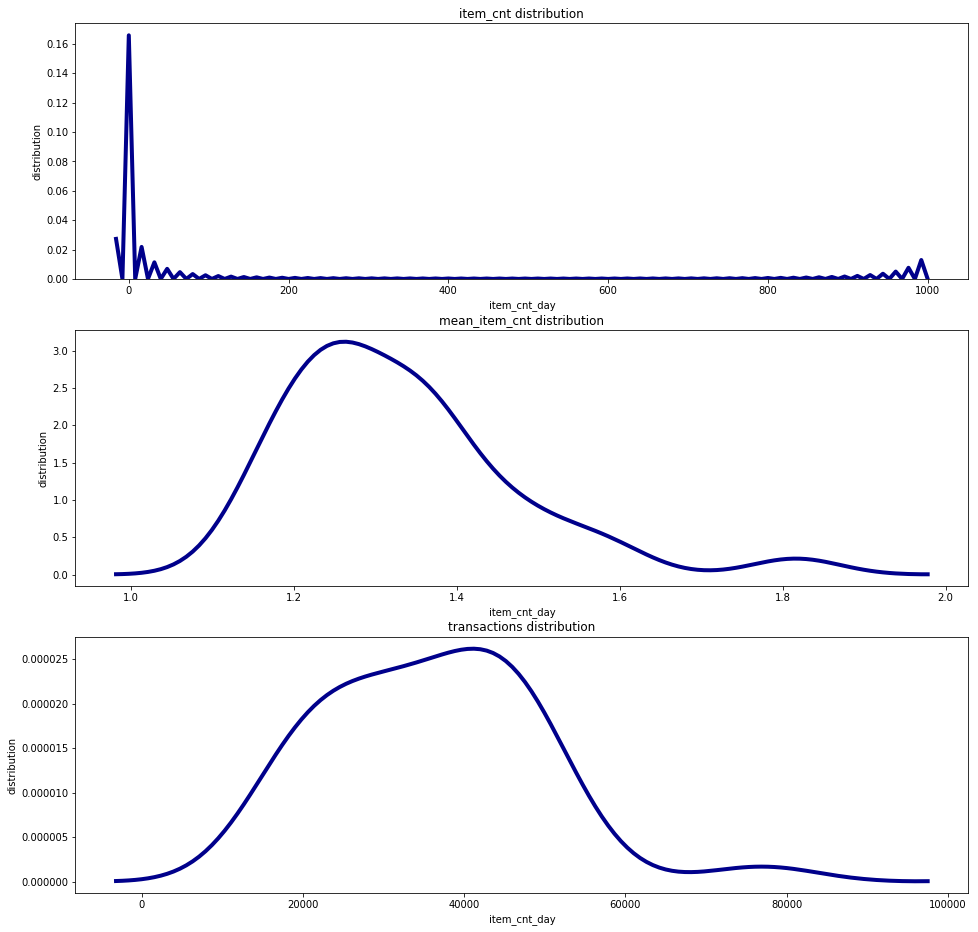

In [28]:
#EXPLORATORY DATA ANALYSIS
#Let's view the distribution of item_cnt,mean_item_cnt & transactions 
#We begin by importing seaborn
import seaborn as sns
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('item_cnt distribution')
plt.xlabel('item_cnt')
plt.ylabel('distribution')
sns.distplot(main['item_cnt_day'], hist=False, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})

plt.subplot(312)
plt.title('mean_item_cnt distribution')
plt.xlabel('mean_item_cnt')
plt.ylabel('distribution')
sns.distplot(main.groupby('date_block_num')['item_cnt_day'].mean(), hist=False, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.plot()

plt.subplot(313)
plt.title('transactions distribution')
plt.xlabel('transactions')
plt.ylabel('distribution')
sns.distplot(main.groupby('date_block_num')['item_cnt_day'].count(), hist=False, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.plot()

#Data seems to be left-skewed, with most item sales averaging 1
#There seems to have 2 "bumps" for transactions, corrsponding to that of transactions over months

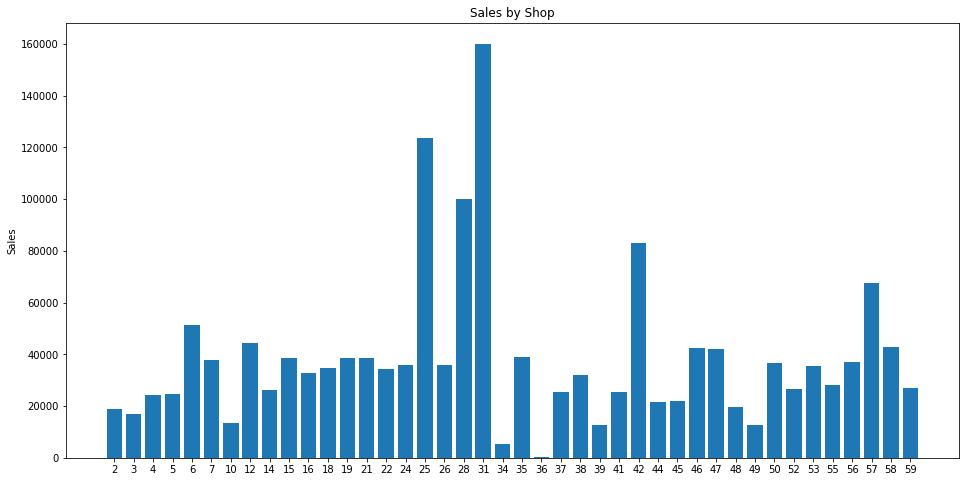

In [29]:
#EXPLORATORY DATA ANALYSIS
#Let's view the distribution of item_cnt BY shop_id
plt.figure(figsize=(16,8))
ts = main.groupby(['shop_id'],as_index=False)['item_cnt_day'].sum()
plt.title('Sales by Shop')
plt.bar(range(len(ts['item_cnt_day'])),list(ts['item_cnt_day']), align='center')
plt.xticks(range(len(ts['shop_id'])),list(ts['shop_id'].unique()))
plt.ylabel('Sales')
plt.show()
#Interestingly, most sales come shop_id 31,25,28,42,57

In [30]:
#EXPLORATORY DATA ANALYSIS
#TIME SERIES STATIONALITY

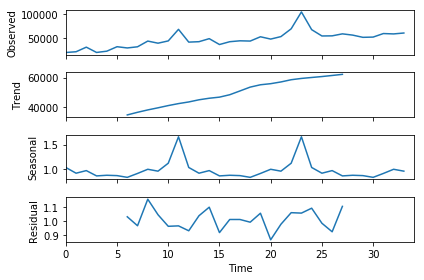

In [31]:
#EXPLORATORY DATA ANALYSIS
#Seems like seasonality is involved
#We check using multiplcative model
ts = main.groupby(['date_block_num'])['item_cnt_day'].sum()
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

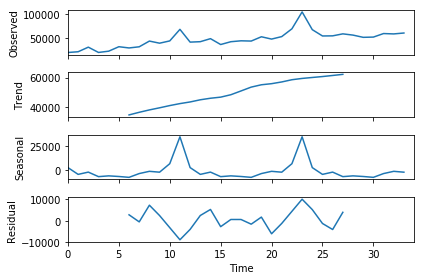

In [32]:
#EXPLORATORY DATA ANALYSIS
#Now we check usng additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()

In [33]:
#EXPLORATORY DATA ANALYSIS
#We create a function for de-trending
from statsmodels.tsa.stattools import adfuller
def difference(dataset,interval=1):
    diff = list()
    for i in range(interval,len(dataset)):
        difference = dataset[i] - dataset[i-interval]
        diff.append(difference)
    return pd.Series(diff)

#We create a function for checking stationarity
def test_stationarity(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [34]:
#EXPLORATORY DATA ANALYSIS
#We create a temp. sum of item_cnt_day for each month
ts = main.groupby(['date_block_num'])['item_cnt_day'].sum()
#Let's check stationarity for original summed data
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.537548
p-value                         0.106604
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


[]

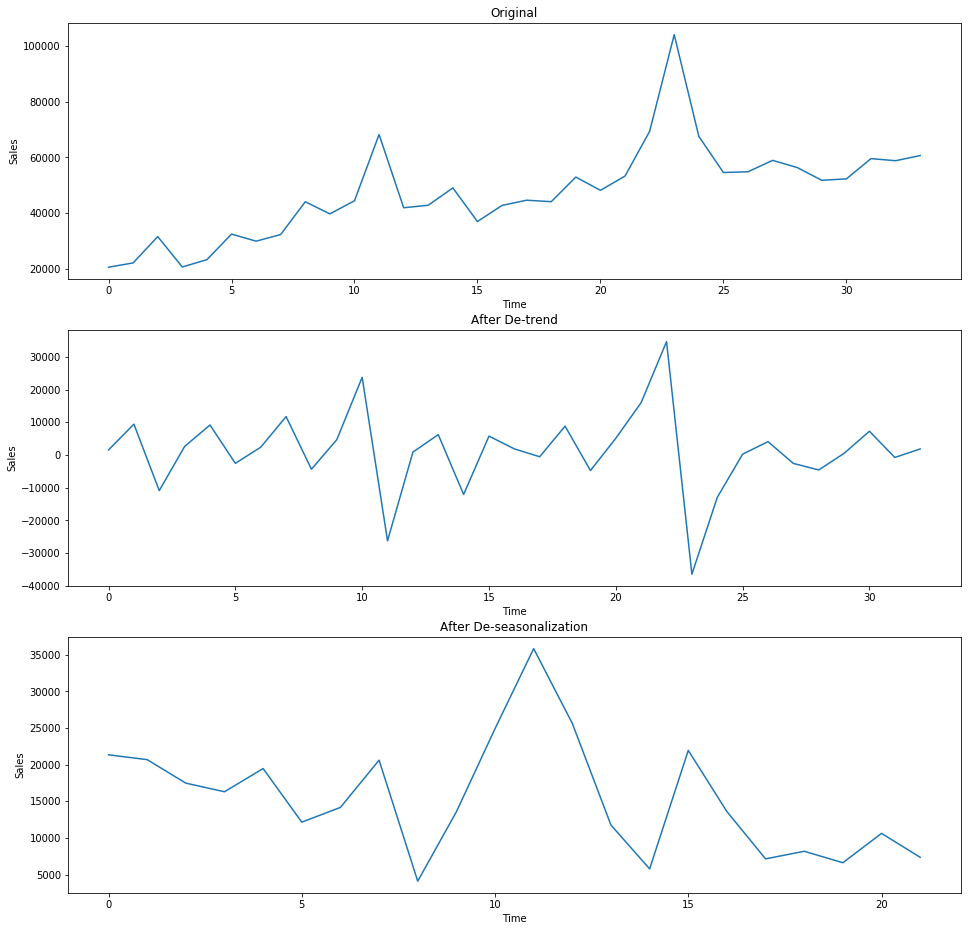

In [35]:
#EXPLORATORY DATA ANALYSIS
#Let's de-trend and print 
import matplotlib.pyplot as plt
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
ts_new = difference(ts)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts_new)
plt.plot()

plt.subplot(313)
ts_new = difference(ts,12)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts_new)
plt.plot()

In [36]:
#EXPLORATORY DATA ANALYSIS
#Let's check stationarity for de-seasonlised data
test_stationarity(ts_new)

Results of Dickey-Fuller Test:
Test Statistic                 -2.914040
p-value                         0.043740
#Lags Used                      1.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


C:\Users\weiquan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


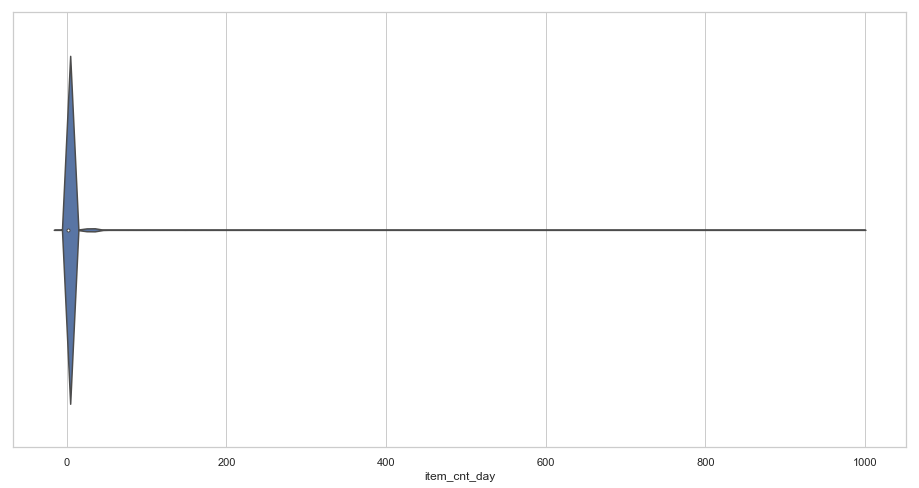

In [37]:
#EXPLORATORY DATA ANALYSIS
#OUTLIERS [item_cnt]
import seaborn as sns
plt.figure(figsize=(16,8))
sns.set(style="whitegrid")
sns.violinplot(x=main["item_cnt_day"])
#There seems to be some outliers, with most points = 1

C:\Users\weiquan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


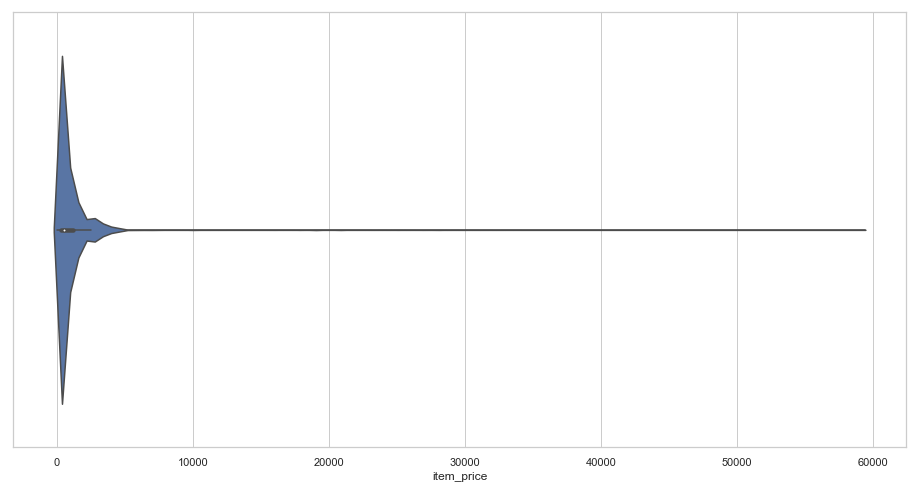

In [38]:
#EXPLORATORY DATA ANALYSIS
#OUTLIERS [item_price]
import seaborn as sns
plt.figure(figsize=(16,8))
sns.set(style="whitegrid")
sns.violinplot(x=main["item_price"])

In [39]:
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,year,month,days
0,0,2,32,0.0,0,40,11,4,0,0,31
1,0,2,33,1.0,0,37,11,1,0,0,31
2,0,2,42,0.0,0,57,13,8,0,0,31
3,0,2,45,0.0,0,57,13,8,0,0,31
4,0,2,51,0.0,0,57,13,8,0,0,31


In [ ]:
#FEATURE ENGINEERING
#MEANS ENCODING

In [40]:
#FEATURE ENGINEERING
#We add mean item_cnt for each month as lag variable
group = main_combined.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
main_combined = pd.merge(main_combined, group, on=['date_block_num'], how='left')
main_combined['date_avg_item_cnt'] = main_combined['date_avg_item_cnt'].astype(np.float16)

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id', 'date_avg_item_cnt']].copy()
lag.columns = ['date_block_num','shop_id','item_id', 'date_avg_item_lag_1']
lag['date_block_num'] += 1
main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_avg_item_lag_1'].fillna(0, inplace=True)  

In [41]:
#FEATURE ENGINEERING
#We add mean item_cnt for each item_id for each month as lag variable
#We use 3 lags since their correlations with date_item_avg_item_cnt are the strongest
group = main_combined.groupby(['date_block_num','item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)
main_combined = pd.merge(main_combined, group, on=['date_block_num','item_id'], how='left')
main_combined['date_item_avg_item_cnt'] = main_combined['date_item_avg_item_cnt'].astype(np.float16)

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id', 'date_item_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','shop_id','item_id', 'date_item_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_item_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_item_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_item_avg_item_lag_3'].fillna(0, inplace=True) 

In [42]:
#FEATURE ENGINEERING
#We add mean item_cnt for each shop_id for each month as lag variable
#Seems like many lags have strong correlation with date_shop_avg_item_cnt
#We shall use 3 lags for now
group = main_combined.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id', 'date_shop_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','shop_id','item_id', 'date_shop_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_shop_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_shop_avg_item_lag_3'].fillna(0, inplace=True) 

In [ ]:
#FEATURE ENGINEERING [CAN't RUN DUE TO MEMORY ERROR]
#We add mean item_cnt for each item_category_id as lag variable
group = main_combined.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_category_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','item_category_id'], how='left')

#Using it as lag feature
#lag = main_combined[['date_block_num','item_category_id','date_item_category_avg_item_cnt']].copy()
#for i in range(1,4):
#    lag.columns = ['date_block_num','item_category_id','date_item_category_avg_item_lag_'+str(i)]
#    lag['date_block_num'] += 1
#    main_combined = pd.merge(main_combined, lag, on=['date_block_num','item_category_id'], how='left')

#Drop date_avg_item_cnt
#main_combined.drop(['date_item_category_avg_item_cnt'], axis=1, inplace=True)
#main_combined['date_item_category_avg_item_lag_1'].fillna(0, inplace=True) 
#main_combined['date_item_category_avg_item_lag_2'].fillna(0, inplace=True) 
#main_combined['date_item_category_avg_item_lag_3'].fillna(0, inplace=True) 

In [ ]:
#FEATURE ENGINEERING [CAN'T RUN DUE TO MEMORY ERROR]
#We add mean item_cnt for each item_category_id as lag variable
group = main_combined.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id', 'item_category_id'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_category_id','date_shop_cat_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','shop_id','item_category_id','date_shop_cat_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_category_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_cat_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_shop_cat_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_shop_cat_avg_item_lag_3'].fillna(0, inplace=True) 

In [43]:
#FEATURE ENGINEERING
#We add mean item_cnt for each shop_id for each type_code
group = main_combined.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id', 'type_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','type_code','date_shop_type_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','shop_id','type_code','date_shop_type_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','type_code'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_type_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_shop_type_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_shop_type_avg_item_lag_3'].fillna(0, inplace=True) 

MemoryError: 

In [44]:
#FEATURE ENGINEERING
#We add mean item_cnt for each shop_id for each subtype_code for each month
group = main_combined.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','subtype_code','date_shop_subtype_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','shop_id','subtype_code','date_shop_subtype_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','subtype_code'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_subtype_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_shop_subtype_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_shop_subtype_avg_item_lag_3'].fillna(0, inplace=True) 

In [ ]:
#FEATURE ENGINEERING
#We add mean item_cnt for each city_code for each month
group = main_combined.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'city_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','city_code','date_city_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','city_code','date_city_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','city_code'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_city_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_city_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_city_avg_item_lag_3'].fillna(0, inplace=True) 

In [49]:
#FEATURE ENGINEERING
#We add mean item_cnt for each item_id for each city_code
group = main_combined.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'item_id','city_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','item_id','city_code','date_item_city_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','item_id','city_code','date_item_city_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','item_id','city_code'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_item_city_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_item_city_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_item_city_avg_item_lag_3'].fillna(0, inplace=True) 

In [54]:
#FEATURE ENGINEERING
#We add mean item_cnt for each type_code
group = main_combined.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'type_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','type_code','date_type_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','type_code','date_type_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','type_code'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_type_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_type_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_type_avg_item_lag_3'].fillna(0, inplace=True) 

In [60]:
#FEATURE ENGINEERING
#We add mean item_cnt for each subtype_code
group = main_combined.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'subtype_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','type_code','date_subtype_avg_item_cnt']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','type_code','date_subtype_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','subtype_code'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_subtype_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_subtype_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_subtype_avg_item_lag_3'].fillna(0, inplace=True) 

In [ ]:
#FEATURE ENGINEERING
#TRENDS
#Using it as lag feature
group = main_combined.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['item_id'], how='left')
main_combined['item_avg_item_price'] = main_combined['item_avg_item_price'].astype(np.float16)

group = main_combined.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

main_combined = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
main_combined['date_item_avg_item_price'] = main_combined['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
for i in range(1,7):
    lag.columns = ['date_block_num','type_code','date_item_avg_item_price_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','item_code'], how='left')

for i in lags:
    main_combined['delta_price_lag_'+str(i)] = \
        (main_combined['date_item_avg_item_price_lag_'+str(i)] - main_combined['item_avg_item_price']) / main_combined['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
main_combined['delta_price_lag'] = main_combined.apply(select_trend, axis=1)
main_combined['delta_price_lag'] = main_combined['delta_price_lag'].astype(np.float16)
main_combined['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

main_combined.drop(fetures_to_drop, axis=1, inplace=True)



In [ ]:
#FEATURE ENGINEERING
#TRENDS
group = main_combined.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id'], how='left')
main_combined['date_shop_revenue'] = main_combined['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['shop_id'], how='left')
main_combined['shop_avg_revenue'] = main_combined['shop_avg_revenue'].astype(np.float32)

main_combined['delta_revenue'] = (main_combined['date_shop_revenue'] - main_combinied['shop_avg_revenue']) / main_combined['shop_avg_revenue']
main_combined['delta_revenue'] = main_combined['delta_revenue'].astype(np.float16)

lag.columns = ['date_block_num','shop_id','delta_revenue']
lag['date_block_num'] += 1
main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id'], how='left')

main_combined.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [ ]:
#FEATURE ENGINEERING
#SPECIAL
cache = {}
main_combined['item_shop_last_sale'] = -1
main_combined['item_shop_last_sale'] = main_combined['item_shop_last_sale'].astype(np.int8)
for idx, row in main_combined.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        main_combined.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num   

In [ ]:
#FEATURE ENGINEERING
#SPECIAL
cache = {}
main_combined['item_last_sale'] = -1
main_combined['item_last_sale'] = main_combined['item_last_sale'].astype(np.int8)
for idx, row in main_combined.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            main_combined.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

In [ ]:
#FEATURE ENGINEERING
#SPECIAL
main_combined['item_shop_first_sale'] = main_combined['date_block_num'] - main_combined.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
main_combined['item_first_sale'] = main_combined['date_block_num'] - main_combined.groupby('item_id')['date_block_num'].transform('min')

In [64]:
main_combined['date_subtype_avg_item_cnt'].corr(main_combined['date_subtype_avg_item_cnt'].shift(3))

0.23971291120740562

In [ ]:
main_combined.head()

In [ ]:
#FINAL PREP
#Remove first 3 months since we used them for lag 
main_combined = main_combined[main_combined['date_block_num'] > 2]

In [ ]:
main_combined.columns()

In [ ]:
main_combined.info()

In [ ]:
#TRAIN/VALIDATION SPLIT
#We skip first 3 months since window=3. 70% train, 30% validation
train_set = train_monthly_filtered.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly_filtered.query('date_block_num >= 28 and date_block_num < 34').copy()

# Create train and validation sets and labels. 
int_features = ['shop_id', 'item_id', 'year', 'month']
X_train = train_set.drop(['item_cnt', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt'].astype(int)
X_validation = validation_set.drop(['item_cnt', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt'].astype(int)
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [ ]:
#TEST
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [ ]:
#TEST
# Replace missing values with the median of each shop.            
for shop_id in X_test['shop_id'].unique():
    for column in X_test.columns:
        shop_median = X_test[(X_test['shop_id'] == shop_id)][column].median()
        X_test.loc[(X_test[column].isnull()) & (X_test['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
#MODELLING
#LGBM with HOLD-OUT
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm as lgb
random_state = 0
lgb_params = {
    "objective" : "regression",
    "metric" : "rmse",
    "boosting": 'gbdt',
    #"max_depth" : -1,
    "num_leaves" : 150,
    #"num_threads" : 8,
    "learning_rate" : 0.01,
    #"bagging_freq": 5,
    "bagging_fraction" : 0.9,
    "feature_fraction" : 0.3,
    #"min_data_in_leaf": 80,
    #"min_sum_hessian_in_leaf" : 10,
    #"tree_learner": "serial",
    #"boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}


input_train = X_train
target_train = Y_train
trn_data = lgb.Dataset(input_train, label=target_train)
val_data = lgb.Dataset(X_validation, label=Y_validation)
evals_result = {}
lgb_clf = lgb.train(lgb_params,trn_data,20000,valid_sets = [trn_data, val_data],early_stopping_rounds=100,verbose_eval = 1000,evals_result=evals_result)
p_valid = lgb_clf.predict(X_validation).clip(0, 20)
score_val = sqrt(mean_squared_error(Y_validation, p_valid))
test_pred = lgb_clf.predict(X_test).clip(0, 20)    
print("Mean RMSE Val_Score is {}".format(score_val))    

In [ ]:
#HYPERPARAMETER-TUNING

gridParams = {
    'learning_rate': [ 0.01,0.008,0.006],
    'num_leaves': [100,150,200],
    'bagging_fraction' : [0.9,0.8,0.7],
    'feature_fraction' : [0.5,0.4,0.3]
}

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    #'learning_rate': 0.1,
    #'num_leaves': 63,
    'tree_learner': 'serial',
    #'feature_fraction': 0.8,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}



model = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    #feature_fraction = params['feature_fraction'],
    #bagging_fraction = params['bagging_fraction'],
    #bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

scoring = {'MSE': 'neg_mean_squared_error'}
grid = GridSearchCV(model, gridParams, verbose=2, cv=2, scoring=scoring, n_jobs=-1, refit='rmse')
# Run the grid
grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

In [ ]:
#ENSEMBLING [MIX]
#TRAIN OTHER MODELS TO OBTAIN MIXING INPUTS
alphas_to_try = np.linspace(0, 1, 1001)
RMSE=0
best=0
alpha=0
var=pd.DataFrame(X_train_level2)
for i in alphas_to_try:
    RMSE=sqrt(mean_squared_error(y_train_level2,i*var['pred_lr']+(1-i)*var['pred_lgb']))
    if RMSE<best:
        best=RMSE
        alpha=i
# YOUR CODE GOES HERE
best_alpha = alpha
r2_train_simple_mix = best

print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, r2_train_simple_mix))


In [ ]:
predictions_final = pd.DataFrame()
predictions_final['ID'] = test['ID']
predictions_final['item_cnt_month'] = test_pred
predictions_final

In [ ]:
predictions_final.to_csv('sales_output.csv',index=False)